In [14]:
import torch
import torch.nn as nn

In [15]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [16]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


In [17]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [18]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")
test()

Success, tests passed!


In [19]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 3
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [22]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
#comment mnist and uncomment below if you want to train on CelebA dataset
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.5MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 461kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.17MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.72MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [23]:
# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [24]:
# initializate optimizer
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

In [25]:
gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )
            gen.train()
            critic.train()

 11%|█         | 101/938 [01:13<10:40,  1.31it/s]

Epoch [0/3] Batch 100/938                   Loss D: -1.3636, loss G: 0.6579


 21%|██▏       | 201/938 [02:25<09:30,  1.29it/s]

Epoch [0/3] Batch 200/938                   Loss D: -1.5196, loss G: 0.7372


 32%|███▏      | 301/938 [03:37<08:12,  1.29it/s]

Epoch [0/3] Batch 300/938                   Loss D: -1.5334, loss G: 0.7418


 43%|████▎     | 401/938 [04:48<06:53,  1.30it/s]

Epoch [0/3] Batch 400/938                   Loss D: -1.5356, loss G: 0.7428


 53%|█████▎    | 501/938 [06:00<05:36,  1.30it/s]

Epoch [0/3] Batch 500/938                   Loss D: -1.5382, loss G: 0.7434


 64%|██████▍   | 601/938 [07:11<04:20,  1.30it/s]

Epoch [0/3] Batch 600/938                   Loss D: -1.5203, loss G: 0.7433


 75%|███████▍  | 701/938 [08:23<03:03,  1.29it/s]

Epoch [0/3] Batch 700/938                   Loss D: -1.5370, loss G: 0.7428


 85%|████████▌ | 801/938 [09:34<01:45,  1.30it/s]

Epoch [0/3] Batch 800/938                   Loss D: -1.5291, loss G: 0.7365


 96%|█████████▌| 901/938 [10:46<00:28,  1.30it/s]

Epoch [0/3] Batch 900/938                   Loss D: -1.4804, loss G: 0.7142


 11%|█         | 101/938 [01:12<10:43,  1.30it/s]

Epoch [1/3] Batch 100/938                   Loss D: -1.4780, loss G: 0.7161


 21%|██▏       | 201/938 [02:23<09:27,  1.30it/s]

Epoch [1/3] Batch 200/938                   Loss D: -1.4485, loss G: 0.7187


 32%|███▏      | 301/938 [03:34<08:09,  1.30it/s]

Epoch [1/3] Batch 300/938                   Loss D: -1.3874, loss G: 0.5185


 43%|████▎     | 401/938 [04:46<06:54,  1.30it/s]

Epoch [1/3] Batch 400/938                   Loss D: -1.3740, loss G: 0.5346


 53%|█████▎    | 501/938 [05:57<05:36,  1.30it/s]

Epoch [1/3] Batch 500/938                   Loss D: -1.2805, loss G: 0.6963


 64%|██████▍   | 601/938 [07:09<04:20,  1.30it/s]

Epoch [1/3] Batch 600/938                   Loss D: -1.3947, loss G: 0.6799


 75%|███████▍  | 701/938 [08:20<03:02,  1.30it/s]

Epoch [1/3] Batch 700/938                   Loss D: -1.3237, loss G: 0.6100


 85%|████████▌ | 801/938 [09:32<01:45,  1.30it/s]

Epoch [1/3] Batch 800/938                   Loss D: -1.3548, loss G: 0.6844


 96%|█████████▌| 901/938 [10:43<00:28,  1.30it/s]

Epoch [1/3] Batch 900/938                   Loss D: -1.3558, loss G: 0.6578


 11%|█         | 101/938 [01:12<10:45,  1.30it/s]

Epoch [2/3] Batch 100/938                   Loss D: -1.2258, loss G: 0.6784


 21%|██▏       | 201/938 [02:23<09:30,  1.29it/s]

Epoch [2/3] Batch 200/938                   Loss D: -1.2481, loss G: 0.5597


 32%|███▏      | 301/938 [03:35<08:11,  1.30it/s]

Epoch [2/3] Batch 300/938                   Loss D: -1.2145, loss G: 0.6322


 43%|████▎     | 401/938 [04:46<06:54,  1.30it/s]

Epoch [2/3] Batch 400/938                   Loss D: -1.0725, loss G: 0.4331


 53%|█████▎    | 501/938 [05:58<05:37,  1.30it/s]

Epoch [2/3] Batch 500/938                   Loss D: -1.1687, loss G: 0.5175


 64%|██████▍   | 601/938 [07:09<04:19,  1.30it/s]

Epoch [2/3] Batch 600/938                   Loss D: -1.2170, loss G: 0.6314


 75%|███████▍  | 701/938 [08:21<03:02,  1.30it/s]

Epoch [2/3] Batch 700/938                   Loss D: -0.9507, loss G: 0.2455


 85%|████████▌ | 801/938 [09:32<01:45,  1.30it/s]

Epoch [2/3] Batch 800/938                   Loss D: -1.1628, loss G: 0.5041


 96%|█████████▌| 901/938 [10:44<00:28,  1.30it/s]

Epoch [2/3] Batch 900/938                   Loss D: -1.1276, loss G: 0.4479


100%|██████████| 938/938 [11:10<00:00,  1.40it/s]


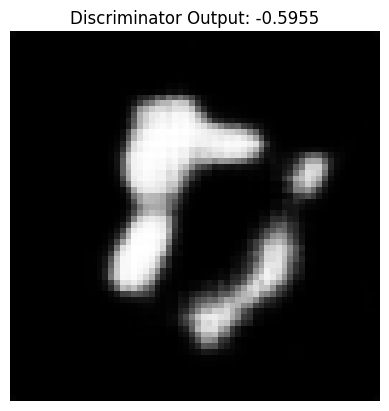

Discriminator's output for the fake image: -0.5954920053482056


In [26]:
import matplotlib.pyplot as plt

# Step 1: Generate a fake image
noise = torch.randn((1,Z_DIM,1,1)).to(device)  # Latent vector for a single fake image
fake_image = gen(noise)  # Generate the fake image

# Step 2: Pass the fake image through the discriminator
critic_output = critic(fake_image)

# Step 3: Visualize the generated fake image
fake_image = fake_image.view(64, 64).cpu().detach().numpy()  # Reshape and move the image to CPU

# Plot the fake image
plt.imshow(fake_image, cmap='gray')
plt.title(f'Discriminator Output: {critic_output.item():.4f}')
plt.axis('off')
plt.show()

# Step 4: Print the discriminator's output
print(f"Discriminator's output for the fake image: {critic_output.item()}")